In [288]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [289]:
# read in all the names
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [290]:
len(words)

32033

In [303]:
# Build vocabulary of chars to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i+1:ch for i, ch in enumerate(chars)}
itos[0] = '.'
vocab_size = len(stoi.keys())


In [308]:
block_size = 3  # Context lents: How many chars will be used to predict the next one
# Build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append for the next char

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [309]:
# Setup MLP
n_embed = 10
n_hidden = 200
C = torch.randn((vocab_size, n_embed))
W1 = torch.randn((n_embed*block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)
for p in params:
    p.requires_grad = True

In [310]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update weights
    lr = 0.1 if i < 10000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track loss
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  20000: 17.4740
   1000/  20000: 3.5876
   2000/  20000: 3.4783
   3000/  20000: 2.2632
   4000/  20000: 3.2073
   5000/  20000: 2.2429
   6000/  20000: 2.7418
   7000/  20000: 2.7388
   8000/  20000: 1.9681
   9000/  20000: 2.1640
  10000/  20000: 2.3936
  11000/  20000: 2.6259
  12000/  20000: 2.4320
  13000/  20000: 2.8795
  14000/  20000: 2.2784
  15000/  20000: 2.0553
  16000/  20000: 2.4990
  17000/  20000: 2.0312
  18000/  20000: 2.2340
  19000/  20000: 2.3775


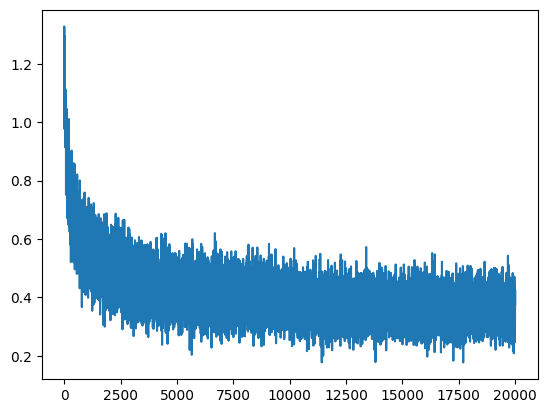

In [311]:
plt.plot(lossi)

In [313]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = torch.tanh(embcat @ W1 + b1)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.321986198425293
val 2.3602240085601807


In [281]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

arail.
eretsy.
iano.
ni.
anie.
ery.
andreed.
ay.
isann.
ila.
irtavaam.
it.
elly.
erabiian.
euia.
eliw.
ayod.
arisaj.
ajahah.
y.
